<a href="https://colab.research.google.com/github/AiloEverything/BKB_Annotation/blob/main/Anno_BKB_Detection_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Top
[End](#scrollTo=Emopj3XqUZMx)

<center>
<h3>Receipt Reading Word Level Annotation</h3>
<h1>BookKeeping Block Annotation</h1>
<h3>Version 10 </h3>
<h2> Runping Li</h2>
<h3> Start on: 2021, Oct. 30</h3>
<h3> Last Modified:  </h3>

</center>

# Introduction

Receipt Cropper has corrected distortions of receipts in images,  made them as rectangles, taken out them from images, and saved them as images. See Figure - 1. The next step is to crop out the blocks conerning with bookkeeping from receipts. In order to create their ground truth to train BookKeep Block(BKB) Model, we must annotates these BKB.

<center>

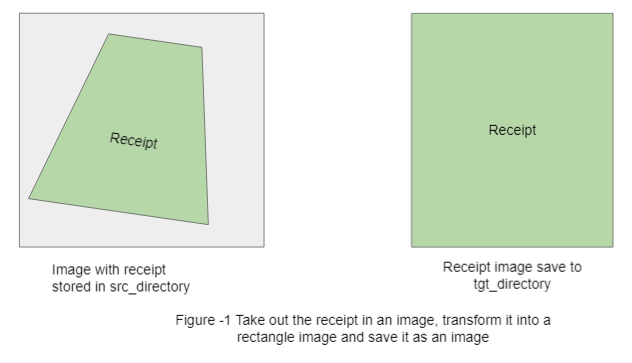

</center>

BKB Annotation means to give labels to BKBs in a receipt and locate their bounding boxes. A BKB is the small area of a receipt which contains a transaction element. A transaction element is the basic information in a receipt to determine the accounts of a transction in  CoA.  The samll area can be any shape, but for the purpose of detection, it is defined as a rectangle. According to its contained transaction element, a BKB is classified  as: 
1. BKB to determine the information of issuer 
1. BKB to determin the date to make a transaction
  1. Source ID, named 'SourceID'
  1. Check close time, named 'CheckCloseTime'
1. BKB to determine the accounts and values of Issuer receivables, 
  1. Issuer receiverable, named 'IssuerReceivable'
  1. BKB to determine the tip and total value paid by receiver
    1. Tip total field, named 'TipTotalField'
1. BKB to determine the payment method and vaues of receiver
  1. Receiver payment, named 'ReceiverPayment'
  1. Non-cash payment information, named 'NonCashPayInfo'
  1. Cash-payment infomation, named 'CashPaymentInfo'
1. BKB to determine the accounts and values of Taxes
  1. Tax-structure, named 'TaxStructure'
1. BKB to determine the information of receiver
  1. Receiver information, named 'DocReceiverInfo'


## 1 BKB to determine the information of issuers
Issuer information is very important to determine the accounts of transactions in CoA. The information includes the name, address and phone of issuers. For the purpose of detection, we are only interested in the name and phone of issuers, because the it is relatively easier to detect a phone than to detect an address and a name. If we know the phone of a business, we can easily to know its name.  

Usually, areas to determine the name and phone of a issuer are in the same block, which is called 'DocIssuerInfo'. But sometimes, the phone is in another area separated from DocIssuerInfo block. The phone is used to allow customer to tell how their experience in their visitaion. So we call this area as 'DocIssuerVisitPhone'. 

Any source document must have a **DocIsserInfo** block, but it may contain or may contain **DocIssuerVisitPhone** block (see figure-1, to figure-3). Here are the blocks to contain issuers' informtion:
  1. Issuer information, named 'DocIssuerInfo'
  1. Issuer visit phone, named 'DocIssuerVisitPhone'

<center>

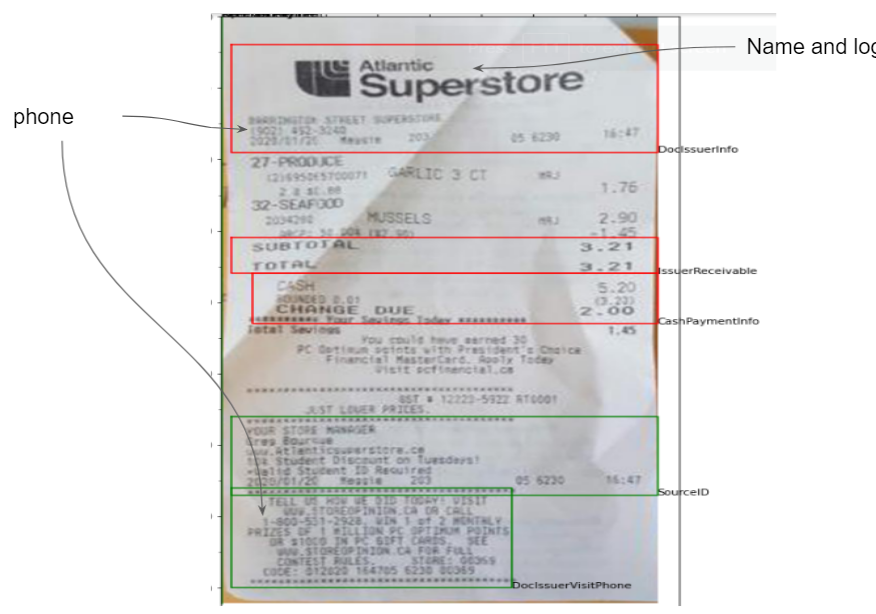

</center>

<center>
Figure-1 A Receipt has both DocIssuerInfo and DocIssuerVisitPhone BKBs. DocIssuerInfo BKB has both phone and name.
</center>

<center>

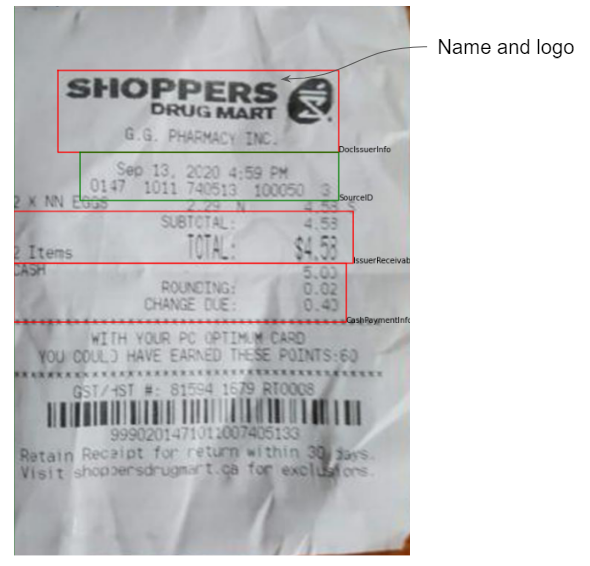

</center>

<center>
Figure-2 A Receipt only has  DocIssuerInfo, which only has name and logo, no phone.
</center>

<center>

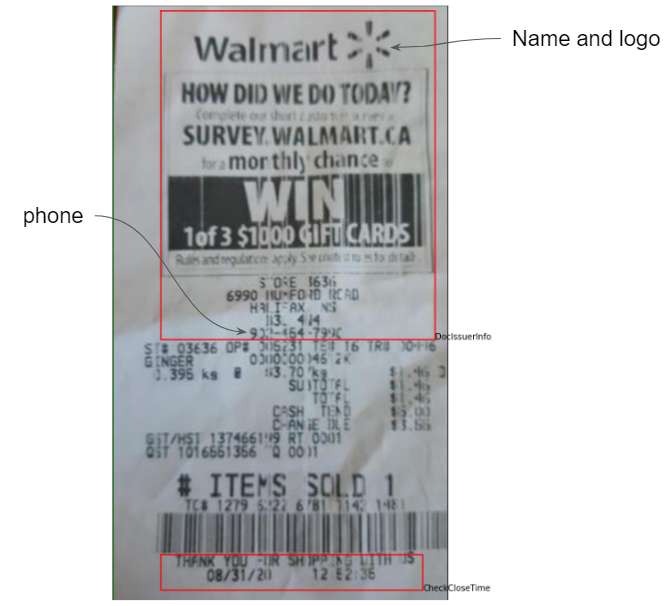

</center>

<center>
Figure-3 A Receipt only hasDocIssuerInfo, which has both phone and name.
</center>

## 2 BKB to determine transaction date
The ID of a source document is very import to track a transaction. We define as SourceID the area which contains the infomation to identify a transaction. For bookkeeping purpose, we are interested in the transaction date it containes. Besides SourceID BKB, sometime, the transaction date appears in the area which shows when the transaction is completed. We name this are as CheckCloseTime BKB, which has word to express the completion, such as 'Thank you', 'Check closed time' (see figure-4 and figure-5). 

<center>

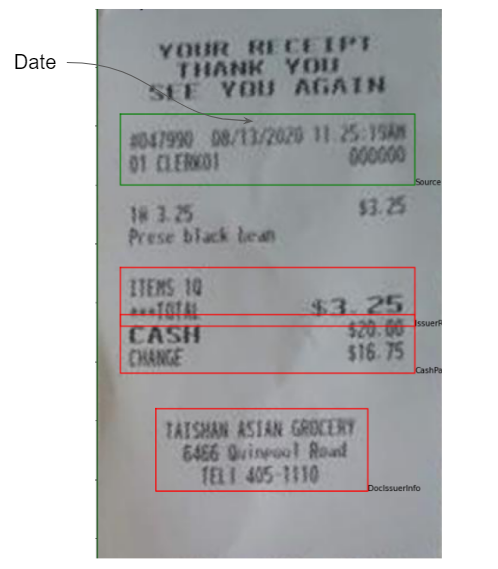

</center>

<center>
Figure-4 A Receipt only SourceID BKB, which has a transaction date.
</center>

<center>

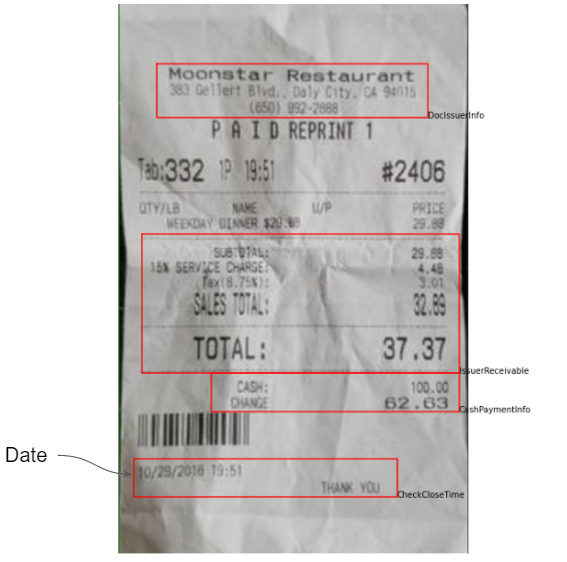

</center>

<center>
Figure-5 A Receipt only has CheckCloseTIme BKB, which has a transaction date.
</center>

## 3 BKB to determine the accounts and values of Issuer receivables
The most import area in a receipt are the area that contains the names and values of items which issuers should receive. This area is names as IssuerReceivable. The names and numbers of the items are variable and depends on the property of a transaction. A typical example is that it will contains subtotal, tax and total (see figure-6). 

<center>

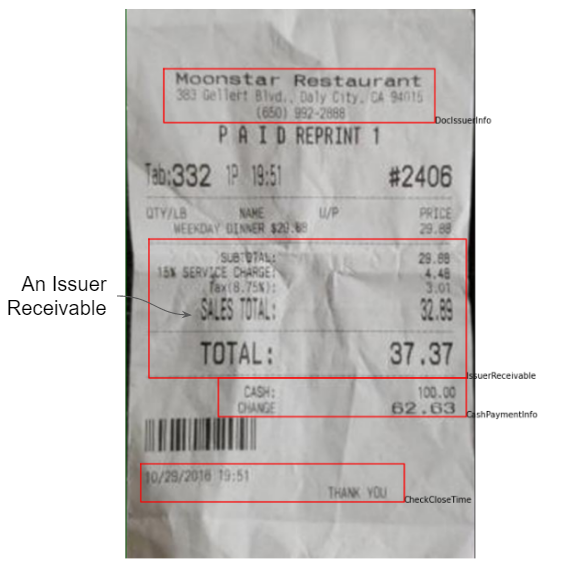

</center>

<center>
Figure-6 A Receipt has IssuerReceivable, which contains two kinds of taxes.
</center>

## 4 BKB to determine the payment method and the vaues a receiver pays
The area that contains how receivers pay and how much they pays is called 'ReceiverPayment'. Sometimes the details to pay are located in other place, which can be classified as CashPaymentInfo, and NonCashPayInfo. The following are the three kinds of payment information.
1. Receiver payment, named 'ReceiverPayment'. It indicates payment method, and values
1. Non-cash payment information, named 'NonCashPayInfo'. It indicates the concrete name of payment method, amount to pay and other details to pay.
1. Cash-payment infomation, named 'CashPaymentInfo'. It indicate the amount to tend with cash

## 5 BKB to determine the accounts and values of Taxes

The area to say how taxes are calculated is called 'TaxStructure'. TaxStructure details the calculation of each tax. 


## 6 BKB to determine the information of receiver
Although receiver information is not important in some document, it is very important in the document, such as invoice. Issuers need this infomation to track who has not pay the transaction. 

We set up necessary environment in advance for smoothly reading this note, before taking annotation. The rest of this note is arranged as : 
1. Setup of environment
1. ReceiptCropperData
1. BookKeeping Block Data
1. Conversion ReceiptCropperData into BookKeeping Block Data
1. Annotation of ground truth of ReceitReading

# I Setup

  [AppGUI](#scrollTo=-7945qekmKEl)

In [1]:
from pathlib import Path
import random
import re
import  time

import numpy as np
import pandas as pd

from shutil import copyfile

In [2]:
#@title Image
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Polygon

from PIL import Image
plt.rcParams['figure.figsize']=(11, 14)
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

In [3]:
#@title pytorch
import torch
from torch.utils.data import Dataset

In [4]:
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
#@title scipy
from scipy.spatial import distance
from skimage import transform
 

In [6]:
#@title process
import threading
import concurrent.futures

In [7]:
#@title progress
from tqdm import tqdm

In [8]:
#@title persistantDisk
import pickle

# II Common Functions and classes

## TestMode

In [9]:
class TestMode():
  RUN = 'to_run'
  TEST = 'to_test'
  MODE = TEST
  @classmethod
  def set(cls):
    cls.MODE = TestMode.TEST
  @classmethod
  def reset(cls):
    cls.MODE = TestMode.RUN
  @classmethod
  def to_test(cls):
    return cls.MODE == cls.TEST

In [10]:
TestMode.set()
# TestMode.reset()
print(TestMode.to_test())

True


## SysConfig

In [11]:
class SysConfig():
  ReceiptCropper_data_parent_path = Path('/content/drive/MyDrive/ai/AiloKeeper/data/working_imgs')
  ReceiptReading_data_root_path= Path('/content/drive/MyDrive/ai/ReceiptReading/data')
  BKB_Detection = 'BKB_Detection'
  BKB_Detection_data_anno_path = ReceiptReading_data_root_path / BKB_Detection / 'Annotations'
  BKB_Detection_data_img_path = ReceiptReading_data_root_path / BKB_Detection / 'ReceiptImages'

# III Uitls

## AngleUnit

In [12]:
class AngleUnit():
  ''' the unit of angle 
  '''  
  # ratio to convert degree to radian. Ex 90 to pi/2
  # 90*deg_to_rad_ratio
  deg_to_rad_ratio = torch.tensor(np.pi/180)
  rad_to_deg_ratio = 1/deg_to_rad_ratio
  #***********************************************************
  @staticmethod
  def degree(radian_amount):
    ''' degree
      convert radian_amount to degree

    - radian{float} - the amount of angle in radian
    '''
    return radian_amount*AngleUnit.rad_to_deg_ratio

  @staticmethod
  def radian(degree_amount):
    ''' radian
      convert degree_amount to radian

    - degree_amount{float} - the amount of angle in degree
    '''
    return degree_amount*AngleUnit.deg_to_rad_ratio

## AffineTransform

In [13]:
class AffineTransform():
  ''' AffineTransform
  Base to affinely transform a point
  Last Modified: 2021, Apr. 23 at 16:25 by rLi

  '''
  
  #****************************************************
  def __call__(self, points):
    '''call

    args:
      points{tensor} - nx2 array of points to be transformed
        n: the number of points
        2: x, y of a point

    '''
    p_type = type(points)

    # added original point
    if(p_type is type([]) or p_type is type(())):
      points = tensor.array(points).reshape(1, -1)
      p_type = type(points)
    if(len(points.shape) is 1):
      points = points.reshape(1, -1)
    points=torch.vstack(
        (torch.zeros((1, 2)).to(points.device), points)
    )#

    n, _ = points.shape
    # add last one's column
    p_t = torch.hstack(
        (points, torch.ones((n, 1)).to(points.device))
    )#

    #  transpose to form vertical point vectors
    self.tran_m = self.tran_m.to(torch.float32).to(points.device)
    p_t = p_t.to(torch.float32)
    p_t = self.tran_m @ p_t.T

    # remove added original point and last one's column
    p_t = p_t[:-1, 1:].T
    # keep the same type as input
    return p_t



## Rotate

In [14]:
class Rotate(AffineTransform):
  ''' Rotate
  Counter clockwise rotate a point. Multiple points can only rotate at 
  an identical angle.
  Last Modified: 2021, Apr. 13

  '''
  def __init__(self, theta):
    ''' initialization

    args:
      theta{float} - the angle to rotate a point in degree unit
        positive: countercloclkwise rotation
        negative: clockwise rotation
        it is a scalar, which means all point rotate at the same angle

    '''
    theta = AngleUnit.radian(theta)
    c_t = torch.cos(theta)
    s_t = torch.sin(theta)
    self.tran_m=torch.tensor(
        [c_t, -s_t, 0,
         s_t, c_t,  0,
            0,  0,  1]
    ).reshape(3,3)

## Translate

In [15]:
class Translate(AffineTransform):
  ''' Translate
  Translate a point
  Last Modified: 2021, Apr. 23 at 15:08 by rLi

  '''
  def __init__(self, x_delta, y_delta):
    ''' initialization

    args:
      x_delta{float} - change of x to translate  a point
      y_delta{float} - change of y to translate  a point

    '''
    super().__init__()
    self.tran_m=torch.Tensor(
        [   1.,  0,  x_delta,
            0.,  1.,  y_delta,
            0.,  0.,        1.
        ]
    ).reshape(3,3)
    

#### test

In [16]:
x = torch.tensor((5.5))
y = torch.tensor((5.5))

translate = Translate(x, y)
print(f'\n translate tensor')
points = torch.tensor((
    [5., 8.], (15., 18.)
))
print(translate(points))


 translate tensor
tensor([[10.5000, 13.5000],
        [20.5000, 23.5000]])


## Axis transform


In [17]:
class AxesTranslation(Translate):
  def __init__(self, new_org):
    ''' initialization

    args:
      new_org{(float, float)} - the original point of new Axes in 
        old axes

    '''
    self.set_org(new_org)
    
  def set_org(self, new_org):
    n_type = type(new_org)
    if(n_type is type([]) or n_type is type(())):
      x_delta, y_delta = new_org
    elif(len(new_org.shape) is 1):
      x_delta, y_delta = new_org[0], new_org[1]
    super().__init__(-x_delta, -y_delta)


#### test
[Predicator](#scrollTo=PLETqeXVPBdO)

In [18]:

newAxisCoord = AxesTranslation(torch.tensor((5, 2)))

print(f'newAxisCoord tensor')
points = torch.tensor((
    [100, 0], [100, 100]
))#

print(newAxisCoord(points))

newAxisCoord tensor
tensor([[95., -2.],
        [95., 98.]])


## ImageDim

In [19]:
class ImageDim():
  '''ImageDim
  Image dim
  Last Modified: 2021, May. 22 at 20:28 by rLi

  '''
  @staticmethod
  def rotated_image_dim(rotate_angle, original_image_dim, is_half_dim=False):
    ''' rotated_image_dim
    find the dim of image which is created by rotating the original
    image around its center. 
     args
      rotate_angle{float} - rotate angle in degree unit to rotate original image
      original_image_dim{sequence/np.ndarray/torch.Tensor} - the dim of original
      image, (width, height)

    '''
    rotate = Rotate(rotate_angle)
    dim_type = type(original_image_dim)
    if(dim_type is type([]) or dim_type is type(())):
      original_image_dim = torch.tensor(original_image_dim).reshape(1, -1)
      dim_type = type(original_image_dim)
    if(dim_type is torch.Tensor):
      top_right_corner = original_image_dim/2
      top_left_corner = top_right_corner.clone().detach()
      if(len(top_left_corner.shape) is 1):
        top_left_corner[0] *= -1
      else:
        top_left_corner[:, 0] *=-1
      top_left_corner = np.abs( rotate(top_left_corner) )
      top_right_corner = np.abs( rotate(top_right_corner) )

    else: raise Exception(f'type error {dim_type} is not [], (), or torch.Tensor')
    # the size of image is always positive

    if(len(top_left_corner.shape) is 1):
      w = np.maximum(np.abs(top_left_corner[0]), np.abs(top_right_corner[0]))
      h = np.maximum(np.abs(top_left_corner[1]), np.abs(top_right_corner[1]))
    else:
      w = np.maximum(np.abs(top_left_corner[:, 0]), np.abs(top_right_corner[:, 0]))
      h = np.maximum(np.abs(top_left_corner[:, 1]), np.abs(top_right_corner[:, 1]))
    dim = np.vstack((w.T, h.T)).T*2
    if(is_half_dim):
      dim /=2
    if(len(dim) is 1):
      dim = [dim[0, 0], dim[0, 1]]
    return dim

  @staticmethod
  def rotated_image_half_dim(rotate_angle, original_image_dim):
    return ImageDim.rotated_image_dim(rotate_angle, original_image_dim, is_half_dim=True)


### test 

In [20]:
def test_Image_dim(r_a=45):
  '''
  args: 
    r_a{float} - rotation angle
  '''
  r_a = 45
  #print(f'rotate angle {type(r_a), r_a.shape, r_a}')
  org_dim = torch.tensor([1000, 1000])
  print(f'test list {org_dim}')
  #print(ImageDim.rotated_image_dim(r_a, org_dim))
  print(f'half dim {ImageDim.rotated_image_half_dim(r_a, org_dim)}')

# to_test = True
to_test = False
if to_test and TestMode.to_test() :
  test_Image_dim(r_a=30)


## PersistantDisk
A virtual Disk to store on-the-fly data


In [21]:
class PersistentDisk():
  ''' PersistantDisK
  A virtual disk is used to store on-the-fly data, which is needed
  to reset initial values of variable so tha an app can start from
  its last stop.
  
  The class use pickle to load and save data
  ref:https://www.datacamp.com/community/tutorials/pickle-python-tutorial#whatcan 

  '''
  def __init__(self, file_name):
    self.file_name = file_name
    self.file_path = SysConfig.BKB_Detection_data_anno_path / self.file_name
  
  #************************************************************************
  def save(self, on_the_fly_data):
    with open(self.file_path, 'wb') as f:
      pickle.dump(on_the_fly_data, f)

  def load(self):
    with open(self.file_path, 'rb') as f:
      return pickle.load(f) 


In [22]:
#@title test
oDisk = PersistentDisk('test.pkl')
test_data = 5
print(f'tst: saved data {test_data}')
oDisk.save(test_data)
load_data = oDisk.load()
print(f'tst: load data {load_data}')


tst: saved data 5
tst: load data 5


# 1 ReceiptCropping

## CropReceipt

### code

In [23]:
class CropReceipt():
  '''CropReceipt
  crop receipt in an image. 
  
  algorithm:
  # 1 get size of original image
  # 2 double size the original image, because the receipt coordinates are taken
    on the basis of double size of original image
  # 3 rotate the image by rotation angle
  # 4 take the receipt from the rotated image by correcting perspective distortion
  correct the distortion caused by perspective transform
  # https://www.inovex.de/de/blog/digitize-receipts-computer-vision/

  '''
  #***********************************************************************

  def __call__(self, org_img, r_angle, rct_coordinates):
    '''
    args
      org_img{PIL image} - original image that contains a receipt
      r_angle{float} - angle to rotate the original image
      rct_coordinates{tensor} - coordinates contains the polygon vertices in 
        clockwise order starting from the upper left corner.
    '''
    # 1 get size of original image
    w, h = org_img.size
    # 2 double size the original image, because the receipt coordinates are taken
    #  on the basis of double size of original image
    img = org_img.resize((2*w, 2*h))
    # 3 rotate the image by rotation angle
    # the unit of angle is degree in pilimage rotate command
    # https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.rotate
    # https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=transform%20estimate#skimage.transform.ProjectiveTransform.estimate
    # https://scikit-image.org/docs/dev/auto_examples/transform/plot_geometric.html#parameter-estimation
    # Because it is hard for people to tell 0.5 degree difference, we adjust
    # the predicted rotation angle to change every 0.5 to avoid the uncessary 
    # prediction error. For example, the real angle is 0 degree, but predicted 
    # angle is usuall around zero, but less than 0.5
    r_img = img.rotate(int(r_angle*10+0.5)/10, expand=True)

    # 4 adjust axes system
    # After converted into numpy, pil image's axes is top-left axes,which means
    # that the top-left corner is (0, 0), but the axes of predicted coordinates
    # is left-bottom axes which means that the left_bottom is (0,0). So it is
    # necessary to convert predicted coordinates into left-top axes before crop
    # according to following formula
    # lta: left_top_axes, lba: left_bottom_axes
    # lta_top_y = h_img - lba_top_y
    # lta_btm_y = h_img - lba_bym_y
    w, h = r_img.size
    # change top and bottom of lba axes coords
    
    
    rct_coordinates[0, 1] = h-rct_coordinates[0, 1] # lba_left_top_y to lta_left_bottom
    rct_coordinates[1, 1] = h-rct_coordinates[1, 1] # lba_right_top_y to lta_right_bottom
    rct_coordinates[2, 1] = h-rct_coordinates[2, 1] # lba_right_bottom_y to lta_right_top
    rct_coordinates[3, 1] = h-rct_coordinates[3, 1] # lba_left_bottom_y to lta_left_top
    # after changing the order of top and bottom, the order of coordintate must
    # to chang to keep  the clockwise order
    # switch lba_coords to lta_coord
    lta_coords = torch.zeros_like(rct_coordinates)
    lta_coords[0, :] = rct_coordinates[3, :] # lta_left_top from lba_left_btm
    lta_coords[1, :] = rct_coordinates[2, :] # lta_right_top from lba_right_btm
    lta_coords[2, :] = rct_coordinates[1, :] # lta_right_btm from lba_left_top
    lta_coords[3, :] = rct_coordinates[0, :] # lta_left_btm from lba_left_top


    # 4 take the receipt from the rotated image by correcting perspective distortion
    # correct the distortion caused by perspective transform
    # copy tensor to cpu memory so that it can be converted into numpy
    d = distance.pdist(lta_coords.cpu())  
    w = int(max(d[0], d[5])) # = max(dist(p1, p2), dist(p3, p4))    
    h = int(max(d[2], d[3])) # = max(dist(p1, p4), dist(p2, p3))    
    # create a projective transform
    tr = transform.ProjectiveTransform()
    src = np.array([[0,h], [w,h], [w,0], [0,0]])
    dst = lta_coords.cpu().detach().numpy()
    # estimate the parameter of transform
    tr.estimate(src, dst )
    # warp    
    receipt = transform.warp(r_img, tr, output_shape=(h, w), order=1, mode="reflect")
    
    return receipt

## ReceiptCropper

In [24]:
class ReceiptCropper():
  '''ReceiptCropper
  crop a receipt in an image

  '''
  #**********************************************************
  def __init__(self, img_dir_name):
    ''' initialization
    args:
      img_dir_name{string} - the name of the directory containing images

    '''
    self.img_parent_path = SysConfig.ReceiptCropper_data_parent_path / img_dir_name
    self.toLeftAxes = AxesTranslation((0, 0))
    self.cropReceipt = CropReceipt()
    
  #**********************************************************
  def __call__(self, img_file_name, rotation_angle, rct_left_axes_corners):
    '''__call__
    
    args:
      img_file_name{string} - the name of file to store an image
      rotation_angle{float} - the angle to rotate image so that the text line of 
        receipt is as horizontal as possible
      rct_left_axes_corners{ndarray} - the left_axes coordinates of corners of receipts in 
        clockwise from left_top to left_bottom, which is taken from double size 
        original image

    algorithm:
      # 1 read image
      # 2 crop receipt

    '''
    # 1 read image
    self.org_img = self._get_org_img(img_file_name)
    self.r_angle = rotation_angle
    # 2. crop receipt
    return self.cropReceipt(self.org_img, rotation_angle, rct_left_axes_corners)

  #*****************************************************************
  def _get_org_img(self, img_file_name):
    img_file_path = self.img_parent_path / img_file_name 
    return Image.open(img_file_path)  
  
  def _get_half_dim_of_rotated_image(self):
    '''
    algorithm:
      # get dim of original image
      # get rotation angle
      # get dim of rotated image
    '''
    # 1. get original image
    org_img = self.org_img # orignial image
    w, h = org_img.size
    
    # 2. get rotation angle
    r_angle = self.r_angle

    # 3 get half dim of rotated image
    # Because the coords are taken from double scale of original image, 
    # so we double the original dimension
    org_dim = (2*w, 2*h) 
    
    return ImageDim.rotated_image_half_dim(r_angle, org_dim)

#***********************************************************************


## ReceiptCropperData

The original images of receipts can not be used to annotate transaction elements. The receipts must be cropped out. The ground truth of receipts in original images, and the images together are called Cropping Data, and the cropped images - images of rectangle receipts with as less background as possible and concerning tables are called ReceiptCropperData

Cropping Data are stored in following three Path
1. /content/drive/MyDrive/ai/AiloKeeper/data/working_imgs/TestSetImgs
1. /content/drive/MyDrive/ai/AiloKeeper/data/working_imgs/TrainSetImgs
1. /content/drive/MyDrive/ai/AiloKeeper/data/working_imgs/ValidSetImgs

Each path consists of images and a pandas file which annotates the images. The name of padas file is :
>"norm_"+path.name+"_gtt.csv"<br>
Ex: norm_ValidSetImgs_gtt.csv

The following shows the format of padas file and an image containing a receipt


### Example

In [25]:
gtt_file_parent = SysConfig.ReceiptCropper_data_parent_path / 'TrainSetImgs'
gtt_file_name = 'norm_'+ gtt_file_parent.name+"_gtt.csv"
gtt_file_path = gtt_file_parent / gtt_file_name
gtt_table = pd.read_csv(gtt_file_path, index_col=0)
gtt_table.head(5)


,cls_type,rotateAngle,x_lft_top,y_lft_top,x_rgt_top,y_rgt_top,x_rgt_btm,y_rgt_btm,x_lft_btm,y_lft_btm
Rct_non__000001.jpg,2.0,0.0,0.0,1000.0,500.0,1000.0,500.0,0.0,0.0,0.0
Rct_non__000002.gif,2.0,0.0,0.0,1000.0,500.0,1000.0,500.0,0.0,0.0,0.0
Rct_non__000004.jpg,0.0,90.0,499.0,542.0,1002.0,539.0,1003.0,-4.0,501.0,0.0
Rct_non__000004.webp,2.0,0.0,0.0,1000.0,500.0,1000.0,500.0,0.0,0.0,0.0
Rct_non__000005.jpeg,1.0,0.0,0.0,1000.0,560.0,1001.0,561.0,68.0,1.0,70.0


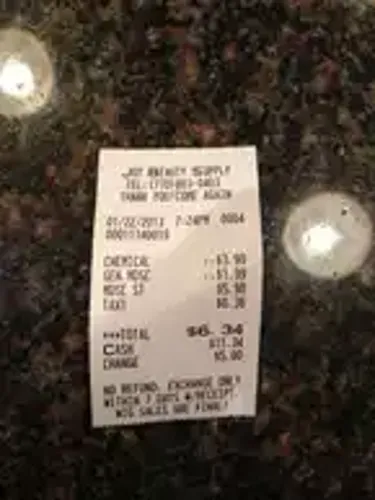

In [26]:
img_file_name = 'Rct_like__000014.webp'
img_file_path = gtt_file_parent / img_file_name
img = Image.open(img_file_path)
img

### code
[dataset-class tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

In [27]:
class ReceiptCropperData(Dataset):
  '''ReceiptCropperData
  provide images of rectangle receipts which contains as less background as 
  possible from orignial images containing a receipt.
  LMD: 2021, Sep. 18
  
    gtt_table # ground truth table of receipts in original images
      columns =[cls_type	rotateAngle	x_lft_top	y_lft_top	x_rgt_top	
        y_rgt_top	x_rgt_btm	y_rgt_btm	x_lft_btm	y_lft_btm]

  '''
  def __init__(self, img_dir_name=None, max_cls_type=2):
    '''
    # attributes:
      .table
    # interface:
    Last Modified: 2021, Sep. 18
    
    args: 
      max_cls_typ{int} - the max number of cls_type, an imge whose cls_type is 
        less than this number is an image with receipt

    '''
    if(img_dir_name is None):
      img_dir_name ='TrainSetImgs'
    self.gtt_parent_path = SysConfig.ReceiptCropper_data_parent_path / img_dir_name
      
    # ReceiptCropper
    # it is responsible for cropping a receipt from an image
    self.rctCropper = ReceiptCropper(img_dir_name)
    
    self.max_cls_type = max_cls_type
    self._create_table()
    
    self.cur_idx = 0
    self.max_len = len(self.table)

  #*************************************************************
  # iterator interface
  def __next__(self):
    if self.cur_idx < self.max_len:
        result = self.__getitem__(self.cur_idx)
        self.cur_idx += 1
        return result
    else:
        raise StopIteration

  def __iter__(self):
    self.cur_idx  = 0
    return self


  # dataset interface
  def __len__(self):
    return len(self.table)
  
  def __getitem__(self, idx):
    img_file_name = self.table.index[idx]
    cls_type = self.table.iat[idx, 0]
    rotation_angle = self.table.iat[idx, 1]
    rct_left_axes_coords = torch.tensor(self.table.iloc[idx, 2:]).reshape(-1, 2)
    rctImg = self.rctCropper (img_file_name, rotation_angle, rct_left_axes_coords)

    return rctImg, cls_type, img_file_name


  #*************************************************************
  def _create_table(self):
    gtt_file_path = self._get_file_path()
    gtt_table = pd.read_csv(gtt_file_path, index_col=0)
    # keep images whose cls_type is less than max_cls_type
    self.table = gtt_table[gtt_table.cls_type<self.max_cls_type]
  
  #********************************************************
  def _get_file_path(self):
    # gtt file name
    table_name = 'norm_'+ self.gtt_parent_path.name+'_gtt.csv'
    return self.gtt_parent_path / table_name

#********************************************************


### test

 type: 1.0 Rct_like__000855.jpg
columns 
 Index(['cls_type', 'rotateAngle', 'x_lft_top', 'y_lft_top', 'x_rgt_top',
       'y_rgt_top', 'x_rgt_btm', 'y_rgt_btm', 'x_lft_btm', 'y_lft_btm'],
      dtype='object')
                      cls_type  rotateAngle  ...  x_lft_btm  y_lft_btm
Rct_non__000004.jpg        0.0         90.0  ...      501.0        0.0
Rct_non__000005.jpeg       1.0          0.0  ...        1.0       70.0
Rct_non__000020.png        1.0          0.0  ...        0.0        0.0
Rct_non__000035.jpg        0.0          0.0  ...      177.0      126.0
Rct_non__000040.jpeg       1.0       -175.0  ...      330.0       23.0

[5 rows x 10 columns]


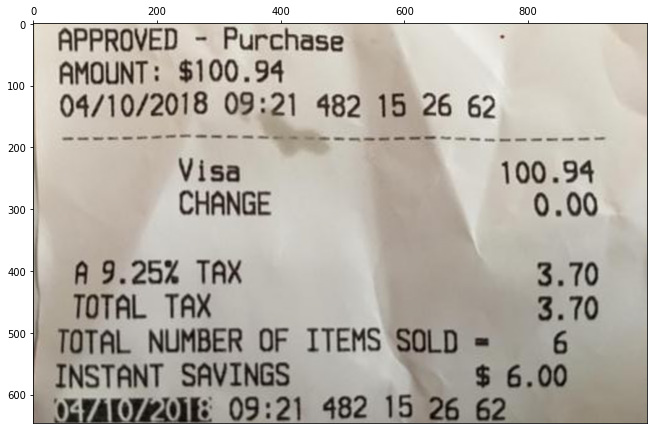

In [28]:
def test_RCD():
  img_dir_names = ['TrainSetImgs', 'ValidSetImgs','TestSetImgs']
  img_dir_name = img_dir_names[0]

  rcDataset = ReceiptCropperData(img_dir_name)
  i=random.choice(range(len(rcDataset)))
  rct_img, cls_type, rct_name = rcDataset[i]
  print(f' type: {cls_type} {rct_name}')
  plt.imshow(rct_img)
  
  print(f'columns \n {rcDataset.table.columns}')
  print(rcDataset.table.head(5))

to_test = True
# to_test = False
if TestMode.to_test() and to_test:
  test_RCD()

# 2 BKB Detection


When the cls_type of an image is 2, the image is not a valid receipt. So we only convert the images whose cls_type is less than 2.

The converted images will be stored in :
>/content/drive/MyDrive/ai/ReceiptReading/data/sub_dir/ReceiptImages

sub_dir is varible which can change as need. In this note, sub_dir is 'BKB_Detection'

Algorithm to convert images in an directory of ReceiptCropper is:
1. read the gtt_table of ReceiptCropper
2. keep images whose cls_type is less than 2
3. for each images
  * read the image
  * rotate the image if necessary
  * get rectangle of the receipt
  * save the receipt into a new file. The file name follows rules:
  ```
    "Rect_Rct_"+code+".jpg". Ex :
    "Rect_Rct_000123.jpg"
  ```


## BKB Data

### code

In [48]:
class BKBDetectionData(Dataset):
  '''BKBDetectionData
  DataFrame to manage image of receipts
  # Attribute:
    table # DataFrame to store receipt name and type
    table_file_path 
  # Interface
    save_rctImg(rct_img, rct_type):
  Last Modified: 2021, Sep. 18

  '''
  CLS_TYPE = 'cls_type'
  ORG_TYPE = 'original_type'

  #********************************************************************
  def __init__(self, image_dir_parent_name, cls_type=None):
    self.RctImgTable_file_path = \
      SysConfig.ReceiptReading_data_root_path / \
        image_dir_parent_name / 'ReceiptImages'

    if(not self.RctImgTable_file_path.exists()):
      self.RctImgTable_file_path.mkdir(parents=True, exist_ok=True)
    self._create_table(cls_type)
    self.max_len = len(self.table)

  #***************************************************************************
  # dataset interface
  def __len__(self):
    return self.max_len

  def __getitem__(self, idx):
    idx = idx % len(self.table)
    img_file_name = self.table.index[idx]
    img_file_path = self.RctImgTable_file_path / img_file_name
    rct_img = Image.open(img_file_path)
    return img_file_name, rct_img
    
  #***************************************************************************
  def void_rctImg(self, idx):
    '''void_rctImg
    set the img as a void receipt image

    '''
    img_file_name = self.table.index[idx]
    print(f'msg: index {idx } type before void of img {img_file_name} is {self.table.loc[img_file_name, self.CLS_TYPE]}')
    self.set_rctType(img_file_name, -1)
  
  def set_rctType(self, img_file_name, cls_type):
    self.table.loc[img_file_name, self.CLS_TYPE] = cls_type
      # save table to file in disk
    self.table = self.table.sort_index()
    self.table.to_csv(self.table_file_path )    

  def save_rctImg(self, rct_img, rct_type):
    '''save_rctImg
      save receipt img and its type
      using thread to concurrently save rct image
      
    args
      rct_img{ndarray} - numpy array of receipt image
      rct_type{int} - cls_type of receipt

    '''
    rct_file_name = 'Rect_rct_'+self._img_num_code()+'.jpg'
    rct_file_path = self.RctImgTable_file_path / rct_file_name
    # save type of receipt
      # update type in table
    self.table.loc[rct_file_name,  self.CLS_TYPE] = rct_type
      # save table to file in disk
    self.table.to_csv(self.table_file_path )
    # save image of receipt
    #https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.fromarray
    #convert to pil image
    #https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type
    # (x * 255).astype(np.uint8)
    img = Image.fromarray((rct_img*255).astype(np.uint8))
    
    # save is a time-spending action, and we do not want to waiting for its end, so
    # we use threading
    #img.save(rct_file_path)
    #simple version 
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
      executor.submit(img.save, rct_file_path)
    # detail version
    # create thread
    #t = threading.Thread(target=img.save, args=(rct_file_path,))
    #t.start() # start thread
    #t.join() # join thread to event loop    

  #***************************************************************************
  def _create_table(self,cls_type=None):
    ''' _create_table
    if the cls_type is None, create table of all images
    if the cls_type is not None, create table of images whose cls_type is le cls_type
    LMD: 2021, Sep. 26

    args:
      cls_type{int} - the type of receipt. Default is None
      
    '''
    if cls_type is None:
      self._create_table_of_all_images()
    else:
      self._create_table_of_clsType_images(cls_type)
  
  def _create_table_of_all_images(self):
    # default table is a table with all images
    table_file_path = self._table_file_path()
    # if table file exists, read it, otherwise, create an empty table
    if(table_file_path.exists()):
      rctImg_table = pd.read_csv(table_file_path, index_col=0)
    else:
      rctImg_table = pd.DataFrame(columns=[ self.CLS_TYPE])
    self.table=rctImg_table
    self.table_file_path = table_file_path
  
  def _create_table_of_clsType_images(self,cls_type):
    '''
    create the table of images whose type is less than cls_type
    pre-condition: cls_type is not None

    args:
      cls_type{int} - the cls_type of an image

    algorithm:
      if table exists, return it
      else:
        create table from table of all images

    '''      
    table_file_path = self._table_file_path(cls_type)
    # if table file exists, read it, otherwise, create the table from
    # table of all images
    if(table_file_path.exists()):
      type_table = pd.read_csv(table_file_path, index_col=0)
      
      type_table= type_table[(type_table[ self.CLS_TYPE]<=cls_type) &
                             (type_table[ self.CLS_TYPE]>=0)]
    else:
      # create the table of _all images and store it in self.table
      self._create_table_of_all_images()
      # type table is the table of images whose type is le cls_type
      type_table= self.table[(self.table[ self.CLS_TYPE]<=cls_type) & 
                             (self.table[ self.CLS_TYPE]>=0)]
      type_table.to_csv(table_file_path)

    self.table=type_table
    self.table_file_path = table_file_path


  def _img_num_code(self, code_len=6):
    num = len(self.table)+1
    num_len = int(np.log10(num))+1
    pre_fix=''.join(['0' for i in range(code_len-num_len)])
    return pre_fix+str(num)

  def _table_file_path(self,cls_type=None):
    '''
    cls_type is None: use the path_name+"_gtt.csv" as table name
    cls_type in not None: use the path_name+"_wkg"+str(cls_type)+"_gtt.csv" as table name
    '''
    RctImgTable_file_path = self.RctImgTable_file_path #for  convenience
    if(cls_type is None):
      RctImg_table_name = RctImgTable_file_path.name+'_gtt.csv'
    else:
      RctImg_table_name = RctImgTable_file_path.name+'_wkg_type_'+str(cls_type)+'_gtt.csv'

    return RctImgTable_file_path / RctImg_table_name

    

### test

In [30]:
def test_rr():
  img_dir_name = 'KeyAsObjectData'
  rrData = ReceiptReadingData(img_dir_name)
  print(rrData._table_file_path())

# to_test = True
to_test = False
if TestMode.to_test() and to_test:
  test_rr()

In [31]:
img_dir_name = 'TestData'
rrData = BKBDetectionData(img_dir_name, cls_type=1)
print(hasattr(rrData, 'save_rctImg') and callable(rrData.save_rctImg))

True


## ConvertToTargetData

### code

In [32]:
class ConvertToTargetData():
  '''ConvertToTargetData
  convert source data to a target Data. 
  takeout receipt from ReceiptCropper data and save it into BKBDetectionData

  # attributes:
  # interface:

  '''
  def __init__(self, tgtData):
    '''initialization

    args:
      tgtData {object} - a target data which will be converted from a source data
        It should have interface:
          save_rctImg(rct_img, rct_type)

    '''    
    # targetData should have interface
    # save_rctImg(rct_img, rct_type)
    # if it has not the function raise an error
    if(not (hasattr(tgtData, 'save_rctImg') and callable(tgtData.save_rctImg))):
      raise Exception(f'target Data {tgtData.__class__.__name__} ' + 
                      f'should have method "save_Image(rct_img, rct_type)"')
    self.tgtData = tgtData

  #**********************************************************************
  def __call__(self, srcData):
    ''' convert source data into target Data
      take out the receipt in each source Data in source data path
      and save it into target Data
  
    args:
      srcData{Object} - source data to be converted

    '''
    # Dataset of ReceiptCropperData
    self.srcDataset = srcData

    data_size = len(self.srcDataset)
    with tqdm(total=data_size) as pBar:
      for item in self.srcDataset:
        
        pBar.set_description(f'create target Data:')
        self._save(item)
        pBar.update(1)

  #**********************************************************************
  def _save(self, item):
    rct_img, rct_type, _ = item
    self.tgtData.save_rctImg(rct_img, rct_type)

# ******************************************************************************

### test

In [33]:
def convert_tgtData():
  tgtData = BKBDetectionData(SysConfig.BKB_Detection, cls_type=1)
  convertToBKBData = ConvertToTargetData(tgtData )
  rc_img_dir_names = ['TrainSetImgs', 'ValidSetImgs', 'TestSetImgs']
  for rc_img_dir_name in rc_img_dir_names:
    srcData = ReceiptCropperData(rc_img_dir_name)
    convertToBKBData(srcData)

to_test = True
# to_test = False
if TestMode.to_test() and to_test:
  # comment to avoid repeat copy
  #convert_tgtData()
  pass

# 3 Annotation of Transaction Elements

In [34]:
#@title class SourceDoc
class SourceDoc():
  ISSURER_INFO = 'DocIssuerInfo'
  SRC_ID = 'SourceID'
  TRANSACTION_DATE = 'TransactionDate'
  ISSURER_RECEIVABLE = 'IssuerReceivable'
  RECEIVER_PAMENT = 'ReceiverPayment'
  NON_CASH_PAY_INFO = 'NonCashPayInfo'
  CASH_PAY_INFO = 'CashPaymentInfo'

  TAX_STRUCTURE = 'TaxStructure'
  
  RECEIVER_INFO = 'DocReceiverInfo'
  CHECK_CLOSE_TIME = 'CheckCloseTime'
  ISSURER_VISIT_PHONE = 'DocIssuerVisitPhone'
  TIP_TOTAL_FIELD = 'TipTotalField'
  

  BKB_NAMES =[ISSURER_INFO, SRC_ID,
    ISSURER_RECEIVABLE, RECEIVER_PAMENT, CASH_PAY_INFO,
    NON_CASH_PAY_INFO, CHECK_CLOSE_TIME , 
    TAX_STRUCTURE, RECEIVER_INFO, ISSURER_VISIT_PHONE,
    TIP_TOTAL_FIELD 
  ]#
  #*************************************
  # future use constant
  
  #*************************************
  # depreciated constant
  TRANSACTION_PAYMENT_INFO = 'TransactionPaymentInfo'


## AnnotationTable
The annotation text file. It is responsible for clear zero data, convert data between diagnal data (two key corners) and dim data(key corner and dim w, h)

### code

In [35]:
class AnnotationTable():
  '''AnnotationTable
  AnnotationTable contains the name of all BKBs and the parameters of their
  bounding boxes. Each line represents a BKB. The names of BKBs are index, and
  columns are top-lft x ,top-lft y, btm-rgt x, btm-rgt y, box-w, box-h
  box-w = btm-rgt x - top-lft x
  box-h = btm-rgt y - top-lft y
  The coordinates are coordinates in image-top-left axes system, which means
  the top-left corner is origin, and right-ward and down-ward are 
  positive x and positive y
  LMD: 2021, Oct. 27 @ 14:04 by rli

  '''
  TOP_LFT_X = 'TL_X'
  TOP_LFT_Y = 'TL_Y'
  BTM_RGT_X = 'BR_X'
  BTM_RGT_Y = 'BR_Y'
  BOX_WIDTH = 'BOX_W'
  BOX_HEIGHT = 'BOX_H'
  TABLE_COLUMNS = [TOP_LFT_X, TOP_LFT_Y, BTM_RGT_X, BTM_RGT_Y, BOX_WIDTH, BOX_HEIGHT]

  def __init__(self, anno_file_stem):
    '''
    arg: 
      anno_file_stem{string} - the stem of an annotation file

    '''
    self.anno_file_parent = SysConfig.BKB_Detection_data_anno_path
    self.anno_txt_file_path = self.anno_file_parent / (anno_file_stem + '.txt')
    self.anno_table_path = self.anno_file_parent /(anno_file_stem + '.csv')
    self._load()

  #********************************************************************
  def get_bbox_to_draw(self, bkb_name):
    '''get_bbox_to_draw
      return:
        the x series and y series  used to draw a bounding box by matlibplot

    '''
    tl_x = self.table.loc[bkb_name, self.TOP_LFT_X] # x of top-left corner
    tl_y = self.table.loc[bkb_name, self.TOP_LFT_Y] # y of top-left corner
    br_x = self.table.loc[bkb_name, self.BTM_RGT_X] # x of bottom-right corner
    br_y = self.table.loc[bkb_name, self.BTM_RGT_Y] # y of bottom-right corner
    return (tl_x, br_x, br_x, tl_x, tl_x), (tl_y, tl_y, br_y, br_y, tl_y)

  def get_bkb_dim_para(self, bkb_name):
    '''get_bkb_dimPara
      get the dimPara (tl_x, tl_y, box_w, box_h) of a BKB
      LMD: 2021, Oct. 28 at 20:26 by rLi

      args:
        bkb_name{string} - the name of a BKB
      return {(float, float, float, float)} - the dimPara 
          (tl_x, tl_y, box_w, box_h) of a BKB
  
    '''
    bkb_box_paras = list(self.table.loc[bkb_name])
    return bkb_box_paras[:2] + bkb_box_paras[4:6]

  def get_bkb_dia_para(self, bkb_name):
    '''get_bkb_diaPara
      get the diagnal Para (tl_x, tl_y, br_x, br_y) of a BKB
      LMD: 2021, Oct. 28 at 20:26 by rLi

      args:
        bkb_name{string} - the name of a BKB
      return {(float, float, float, float)} - the dimPara 
          (tl_x, tl_y, br_x, br_y) of a BKB
  
    '''
    bkb_box_paras = list(self.table.loc[bkb_name])
    return bkb_box_paras[:4] 
  
  def get_bkb_names(self):
    return self.table.index

  def replace_bkb_name(self, old_name, new_name):
    bkb_names = list(self.table.index)
    if old_name in bkb_names:
      bkb_names[bkb_names.index(old_name)] = new_name
      self.table.index = bkb_names
      # save to disk
      self.save()

  def delete_bkb_name(self, bkb_name):
    if(len(self.table)>1):
      self.table=self.table.drop(index=[bkb_name])
      self.save()

  def save(self):
    self.table = self.table.sort_values(by=[self.TOP_LFT_Y])
    self.table.to_csv(self.anno_table_path)

  def add_dim_para(self, bkb_name, dim_para):
    '''add_dim_para
    add dim paras of bbox of a BKB into this table.
    dim paras is the coordinates of top-left corner of BKB, and the dimension
    of its bbox [tl_x, tl_y, box_w, box_h]. sum of these four values must be
    greater than zero

    arg:
      bkb_name{string} - the name of a BKB
      dim_para{ndarray} - the numpy array of paras of a BKB with dimension
        [tl_x, tl_y, box_w, box_h]

    '''
    # only record non-zero BKB box
    para_sum = sum(dim_para)
    if para_sum>0:
      for col, para in zip(self.TABLE_COLUMNS[:2]+self.TABLE_COLUMNS[4:6], dim_para[:4]):
        self.table.loc[bkb_name, col] = para
    self.table[self.BTM_RGT_X] = \
      self.table[self.BOX_WIDTH] + self.table[self.TOP_LFT_X]
    self.table[self.BTM_RGT_Y] = \
     self.table[self.BOX_HEIGHT] + self.table[self.TOP_LFT_Y]
    self.save()

  def add_dia_para(self, bkb_name, dia_para):
    '''add_dia_para
    add dia paras of bbox of a BKB into this table.
    dia paras is the coordinates of two key corners of BKB of its bbox 
      [tl_x, tl_y, br_x, br_y]. sum of these four values must be
    greater than zero

    arg:
      bkb_name{string} - the name of a BKB
      dia_para{ndarray} - the numpy array of coordinates of a BKB two key corners
        [tl_x, tl_y, br_x, br_y]

    '''
    # only record non-zero BKB box
    para_sum = sum(dia_para)
    if para_sum>0:
      for col, para in zip(self.TABLE_COLUMNS[:4], dia_para[:4]):
        self.table.loc[bkb_name, col] = para
    self.table[self.BOX_WIDTH] = \
      self.table[self.BTM_RGT_X] - self.table[self.TOP_LFT_X]
    self.table[self.BOX_HEIGHT] = \
      self.table[self.BTM_RGT_Y] - self.table[self.TOP_LFT_Y]
    self.save()

  #********************************************************************
  def _load(self):
    '''
    load data into table
    LMD: 2021, Oct. 27 at 14:14 by rLi
    algorithm:
      if csv file of the table exists, read the csv file into table
      otherwise,  
        # 1 create an empty table, 
        # 2 read txt file into the table
    '''
    if self.anno_table_path.exists():
      self.table = pd.read_csv(self.anno_table_path, index_col=0)
      if(len(self.table)<1):
        self._set_default_table()

    else:
      self._load_from_text_file()
  
  def _load_from_text_file(self):
    '''
    load data into table from text file
    LMD: 2021, Oct. 27 at 14:25 by rLi

    '''
    self._create_empty_table()
    try:
      # put data in txt file into table
      with open(self.anno_txt_file_path, 'r') as f:
        for line in f:
          # each line consists of BKB name, tl_x, tl_y, br_x, br_y
          # separated by blank space
          bkb_para = line.split()
          bkb_name = bkb_para[0]
          dia_paras = np.array(bkb_para[1:5], dtype=np.float)
          self.add_dia_para(bkb_name, dia_paras)
          
        # update width and height
        self.table[self.BOX_WIDTH ] = self.table[self.BTM_RGT_X]-self.table[self.TOP_LFT_X]
        self.table[self.BOX_HEIGHT] = self.table[self.BTM_RGT_Y]-self.table[self.TOP_LFT_Y]
    except:
      # no txt file, set defaulft Issuer infomation
      self._set_default_table()

  def _set_default_table(self):
      bkb_name = SourceDoc.ISSURER_INFO
      dia_para =[0, 0, 100, 100]
      self.add_dia_para(bkb_name, dia_para)
      self.save()

  def _create_empty_table(self):
    self.table = pd.DataFrame(columns=self.TABLE_COLUMNS)


In [36]:
#@title test
#anno_file_stem = 'Rect_rct_000001_BKBDetectionData'
anno_file_stem = 'Rect_rct_001768_BKBDetectionData'
oAT = AnnotationTable(anno_file_stem)
oAT._load()
bkb_name = SourceDoc.ISSURER_INFO 
print(f'd: {oAT.get_bkb_dim_para(bkb_name)} ')

d: [60.0, 0.0, 360.0, 300.0] 


In [37]:
table = pd.DataFrame(index=['c','a', 'b'], columns=["C", "B","A"], data=np.arange(9).reshape(3,3))
table=table.sort_index()
table=table.sort_values(by=['C'])
table

,C,B,A
c,0,1,2
a,3,4,5
b,6,7,8


In [38]:
ind_lst = list(table.index)
ind_lst[ind_lst.index('a')]='ddd'
table.index = ind_lst
table

,C,B,A
c,0,1,2
ddd,3,4,5
b,6,7,8


## DisplayAnnotation()
display the BKBs of annotation

### code


In [39]:
class DisplayAnnotation():
  '''AnnotationDisplay
  This class is responsible for displaying the BKBs of receipt in an annotation
  file

  '''
  ANNO_FILE_AFFIX = '_BKBDetectionData'
  def __init__(self, ax ):
    '''
      args:
        anno_file_stem{string} - the stem of an annotation file. 
          ex: "Rect_rct_001768_BKBDetectionData" is the stem of following
            three kinds of files:
            Rect_rct_001768_BKBDetectionData.csv
            Rect_rct_001768_BKBDetectionData.txt
            Rect_rct_001768_BKBDetectionData.jpg

    '''
    
    self.anno_img_file_parent = SysConfig.BKB_Detection_data_img_path
    self.annoTable = None
    self.ax = ax

  #*****************************************************************************
  def save_anno(self):
    '''save_anno
    save annotation to disk

    '''
    self.annoTable.save( )
  
  def replace_bkb_name(self, old_name, new_name):
    '''
    replace the bkb_name in annotation table

    '''
    self.annoTable.replace_bkb_name(old_name, new_name)
  
  def delete_bkb_name(self, bkb_name):
    '''
    delete the bkb_name in annotation table

    '''
    self.annoTable.delete_bkb_name(bkb_name)

  def get_bkb_dia_para(self, bkb_name):
    '''get_bkb_dimPara
      get the dimPara (tl_x, tl_y, box_w, box_h) of a BKB
      LMD: 2021, Oct. 28 at 20:26 by rLi

      args:
        bkb_name{string} - the name of a BKB
      return {(float, float, float, float)} - the dimPara 
          (tl_x, tl_y, br_x, br_y) of a BKB
  
    '''
    return self.annoTable.get_bkb_dia_para(bkb_name)

  def get_bkb_names(self):
    if self.annoTable is None:
      return SourceDoc.BKB_NAMES
    else:
      return self.annoTable.get_bkb_names()

  def add_dia_para(self, bkb_name, dia_para):
    '''add_dim_para
    add dim paras of bbox of a BKB into AnnotationTable.
    dim paras is the coordinates of top-left corner of BKB, and the dimension
    of its bbox [tl_x, tl_y, br_x, br_y]. sum of these four values must be
    greater than zero

    arg:
      bkb_name{string} - the name of a BKB
      dim_para{ndarray} - the numpy array of paras of a BKB with dimension
        [tl_x, tl_y, br_x, br_y]

    '''
    self.annoTable.add_dia_para(bkb_name, dia_para)

  #*****************************************************************************
  def __call__(self, anno_img_file_stem=None ):
    if anno_img_file_stem is not None:
      # use new image
      anno_txt_file_stem = anno_img_file_stem + self.ANNO_FILE_AFFIX
      self.annoTable = AnnotationTable(anno_txt_file_stem)    

      self.anno_img_file_path = self.anno_img_file_parent / (anno_img_file_stem +'.jpg')
    # draw image
    self.img = Image.open(self.anno_img_file_path)
    self.ax.imshow(self.img)
    # draw BKBs
    i = 0
    for bkb_name in self.annoTable.table.index:
      color = 'r' if i%2==0 else 'g'
      self._draw_bkb(bkb_name, color)
      i += 1
    # set minor tick
    self.ax.xaxis.set_minor_locator(MultipleLocator(50))
    self.ax.yaxis.set_minor_locator(MultipleLocator(50))

  
  def _draw_bkb(self, bkb_name, color):
    xs, ys = self.annoTable.get_bbox_to_draw(bkb_name)
    self.ax.plot(xs, ys, color)
    self.ax.text(xs[2], ys[2],  bkb_name)


# 4 GUI by class
rewrite the GUI by function to make GUI is more readable 

In [40]:
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, clear_output
gui_output = widgets.Output()

In [41]:
#@title ABkbParaRecorder
class ABkbParaRecorder():
  '''ABkbParaRecorder
  to record the parameters of a BKB input by users

  '''
  USE_OLD_NAME = 'use_old_name'
  EDIT_ADD = 'ADD'
  EDIT_MOD = 'MODIFY'
  EDIT_DEL = 'DELETE'
  EDIT_ACTIONS = ['NO_EDIT', EDIT_ADD, EDIT_MOD, EDIT_DEL]
  ACTION_SAVE = 'save'

  #***********************************************************
  def __init__(self, change_bkb_name, click_save_para, replace_bkb_name, 
               add_bkb_dia_para, delete_bkb_name):
    '''
      create the a HBOX which contains
      The firs is a DropDown used to select BKB_id, 
      the 2nd is a Dropdown used to select grid_unit_num of a BKB 
      others are IntTexts allowing users to input the parameters of
        a BKB:  left, right, top_offset, btm_offset

      args:
        bkb_names{list of string} - the names of all BKBs in an 
          receipt
        change_bkb_name{function} - handler to handle the change of BKB_name
        replace_bkb_name{function} - handler to handle the 
          replacement of BKB_name 
        add_bkb_dia_para{function} - handler to handle the addition 
          of new BKB and it para
          
    '''
    self.click_save_para = click_save_para
    self.replace_bkb_name = replace_bkb_name
    self.add_bkb_dia_para = add_bkb_dia_para
    self.delete_bkb_name = delete_bkb_name

    # the widgets to accept the input of users
    self.bkb_names = SourceDoc.BKB_NAMES

    layout = Layout(width='5%')
    layout_10 = Layout(width='10%')
    # recorder labels
    self.lbl_row = [widgets.Label(lbl, layout=lot) for 
        lbl,lot in zip(
          ['bkb_name', 'TL_X', 'TL_Y', 'BR_X', 'BR_Y', 'BKB_PARA', 
              'Mod_name', 'edit action'],
          [layout_10, layout, layout, layout, layout, layout_10, 
              layout_10, layout_10],
        )#
       ]#
    
    self.btn_keep_para = widgets.Button(
        description=self.ACTION_SAVE, layout=layout_10)
    #self.btn_keep_para.on_click(click_save_para)
    self.btn_keep_para.on_click(self._click_btn_keep_para)

    self.edit_action = widgets.Dropdown(
        options=self.EDIT_ACTIONS, layout=layout_10)
    self.edit_action.observe(self._change_edit_action)

    self.recorders =\
      [ widgets.Dropdown( 
          options = self.bkb_names, layout=layout_10)] + \
      [ widgets.IntText(layout=layout) for i in range(4)] + \
      [ self.btn_keep_para, 
        widgets.Dropdown( 
            options = [self.USE_OLD_NAME] + SourceDoc.BKB_NAMES, 
            layout=layout_10),
        self.edit_action
      ]#
    # observe the change of select BKB_name   
    self.wkgDropdown = self.recorders[0]
    self.recorders[0].observe(change_bkb_name)

    # observe the change of select modified name of BKB
    self.modDropdown = self.recorders[6]
    self.modDropdown.observe(self._change_mod_name)
  
  #**************************************************************
  def __call__(self):
    return widgets.VBox((
      widgets.HBox(self.lbl_row),
      widgets.HBox(self.recorders)
    ))#
  
  #**************************************************************
  def reset_BKB(self):
    self.recorders[0].value = None
    self.recorders[0].value = self.bkb_names[0]
    self.modDropdown.value = self.USE_OLD_NAME
    
  def set_bkb_names(self, bkb_names):
    self.bkb_names = bkb_names
    self.recorders[0].options = bkb_names
    self.reset_BKB

  def get_BKB_name(self):
    return self.recorders[0].value
  
  def move_to_next_BKB(self):
    cur_name = self.recorders[0].value
    bkb_names = list(self.bkb_names)
    next_id = (bkb_names.index(cur_name) + 1) % \
      len(bkb_names)
    self.recorders[0].value =  self.bkb_names[next_id]

  def get_bkb_dia_para(self):
    '''get_para
      get the  parameter of a BKB
      return {[int,...]} - [tl_x, tl_y, br_x, br_y]

    '''

    return [w.value for w in self.recorders[1:5 ] ]

  def update_bkb_para(self, BKB_name, BKB_para):
    # the last recorder is the new name of BKB, which will not
    # be updated
    if BKB_para is None:
      self.recorders[0].value = BKB_name
    else:
      for v, w in zip ([BKB_name]+list(BKB_para), self.recorders[:5]):
        w.value =v
  
  #**************************************************************
  def _click_btn_keep_para(self, obj):
    if obj.description==self.EDIT_DEL:
      # delete bkb_name in working BKB

      # 1 get the bkb_name in the working Dropdown 
      wkg_name = self.wkgDropdown.value
      # 2 delete wkge_name in annotation table
      self.delete_bkb_name(wkg_name)
    else: # save para of BKB
      self.click_save_para(obj)
    _
  def _change_edit_action(self,change):
    new_action = change['new']
    if new_action in change['owner'].options:
      if new_action == self.EDIT_DEL:
        self.btn_keep_para.description=self.EDIT_DEL
        self.lbl_row[5].value = 'BKB_NAME'
      else:
        self.btn_keep_para.description = self.ACTION_SAVE
        self.lbl_row[5].value = 'BKB_PARA'


  def _change_mod_name(self, change):
    edit_action = self.edit_action.value
    
    if edit_action == self.EDIT_ADD:
      self._edit_add(change)
    elif edit_action == self.EDIT_MOD:
      self._edit_modify(change)

  def _edit_add(self, change):
    # add name to  working BKB
    mod_name = change['new']
    if mod_name != change['owner'].options[0] and \
        mod_name in change['owner'].options:
      # if the modified name is not the first selection, here is
      # 'use old name', modifiy the name of working BKB
      # 1. get the name of the working BKB
        #working Dropdown of BKB names is the first recorder 
      wkg_name = self.wkgDropdown.value 
      # 2. get the list of options of working Dropdown
      wkg_option = list(self.wkgDropdown.options)

      # 3 if mod_name is not in wkg_option, add mod_name. 
      # otherwise, this is a duplicate execution, no addition is needed 
      if mod_name  not in wkg_option:
        #wkg_option.append(mod_name)
        # 4 set modified name to initial state to prevent furthur edit
        change['owner'].value = change['owner'].options[0]
        # 5 add mode_name into annotation table
        self.add_bkb_dia_para(mod_name, self.get_bkb_dia_para())
        # 6 set the value of working Dropdown to mod_name
        self.wkgDropdown.value  = mod_name
      # 7 set modified Dropdown to intial state t
      change['owner'].value=change['owner'].options[0]

  def _edit_modify(self, change):
    '''change_mod_name
      change the name of a BKB with the name in the Dropdown 
        of moidified BKB names, which observes this function
         
      algorithm:
        1. get the current name and new name of a BKB
        2. replace the value of bkb_name dropDown
          # when change the value of dropdown
        3. delete the current name record in table
    '''
    # modified name to replace the name of working BKB
    mod_name = change['new']
    if mod_name != change['owner'].options[0] and mod_name in change['owner'].options:
      # if the modified name is not the first selection, here is
      # 'use old name', modifiy the name of working BKB
      # 1. get the name of the working BKB
        #working Dropdown of BKB names is the first recorder 
      wkg_name = self.wkgDropdown.value 
      # 2. get the list of options of working Dropdown
      wkg_option = list(self.wkgDropdown.options)
      
      # 3 if mod_name is not in wkg_option, replace wkg_name with mod_name. 
      # otherwise, wkg_name has been modified, this is a duplicate execution
      # because of system, just ignore, no replacement is needed 
      if mod_name  not in wkg_option:
        wkg_option[wkg_option.index(wkg_name)] = mod_name
        # 4 set modified name to initial state to prevent furthur replace
        change['owner'].value = change['owner'].options[0]
        # 5 replace the old bkb_name in annotation table with mod_name
        self.replace_bkb_name(wkg_name, mod_name)
        # 6 set the value of working Dropdown to mod_name
        self.wkgDropdown.value  = mod_name
      # 7 set modified Dropdown to intial state t
      change['owner'].value=change['owner'].options[0]

      

In [42]:
#@title ShowAnnotation
class ShowAnnotation():
  '''ShowAnnotation
    show annotation of an image

  '''
  def __init__(self, ax ):
    # store the the file name and cls_type of a deleted image
    # it used to restore.
    # The item is (img_file_name, cls_type)
    self.ax = ax
    self.deleted_img_file_name_type=[]
    self.anotation_dir_parent_name = SysConfig.BKB_Detection
    self.displayAnnotation = DisplayAnnotation(ax)
    self.udpate_dataset()
    
  #**********************************************************
  def save_anno(self):
    '''
    save annotation to disk

    '''
    self.displayAnnotation.save_anno()
  
  def replace_bkb_name(self, old_name, new_name):
    '''
      replace the bkb_name in annotation table

    '''
    self.displayAnnotation.replace_bkb_name(old_name, new_name)
    self.draw(use_new_file=False)

  def delete_bkb_name(self, bkb_name):
    '''
      delete the bkb_name in annotation table
    
    '''
    self.displayAnnotation.delete_bkb_name(bkb_name)
    self.draw(use_new_file=False)   

  def udpate_dataset(self):
    self.tgtDataset = BKBDetectionData(
        SysConfig.BKB_Detection, cls_type=1); 
    self.img_nums = len(self.tgtDataset )

  def update(self, img_idx = 0 ): 
    self.udpate_dataset()
    self.img_file_name, _ = self.tgtDataset[img_idx]
  

  def get_bkb_dia_para(self, bkb_name):
    '''get_bkb_dimPara
      get the dimPara (tl_x, tl_y, br_x, br_y) of a BKB
      LMD: 2021, Oct. 28 at 20:26 by rLi

      args:
        bkb_name{string} - the name of a BKB
      return {(float, float, float, float)} - the dimPara 
          (tl_x, tl_y, br_x, br_y) of a BKB
  
    '''
    return self.displayAnnotation.get_bkb_dia_para(bkb_name)
  
  def get_bkb_names(self):
    return self.displayAnnotation.get_bkb_names()

  def add_dia_para(self, bkb_name, dia_para):
    '''add_dim_para
    add dim paras of bbox of a BKB into AnnotationTable.
    dim paras is the coordinates of top-left corner of BKB, and the dimension
    of its bbox [tl_x, tl_y, br_x, br_y]. sum of these four values must be
    greater than zero

    arg:
      bkb_name{string} - the name of a BKB
      dia_para{ndarray} - the numpy array of paras of a BKB with dimension
        [tl_x, tl_y, br_x, br_y]

    '''
    self.displayAnnotation.add_dia_para(bkb_name, dia_para)

  def draw(self, use_new_file=True):
    if use_new_file:
      # the stem of image file to be annotated
      anno_img_file_stem = self.img_file_name.split('.')[0]
      self.displayAnnotation(anno_img_file_stem )
    else:
      self.displayAnnotation( )

      
  def save_annotation(self, to_append):
    '''save
      args:
        to_append{boolean} - 
          True: append the BKB to an annotation file
            if the file does not exist, create a new file
          False: write the BKBs an annotation file, if the file exists
            overwrite ti 

    '''
    self.annotator.save_anotation(to_add=to_append)

  def discard_img(self, img_id):
    '''discard_img
      discard the image with id img_id
    '''
    table = self.tgtDataset.table
    img_file_name = table.index[img_id]
    cls_type = table.loc[img_file_name, BKBDetectionData.CLS_TYPE]
    self.deleted_img_file_name_type.append(
        (img_file_name, cls_type)
    )#
    self.tgtDataset.void_rctImg(img_id)

  def restore_img(self ):
    if(self.deleted_img_file_name_type):
      name_type =  self.deleted_img_file_name_type.pop()
      #self.annotator.set_rctType(*name_type)
      self.tgtDataset.set_rctType(*name_type)
  


In [50]:
#@title ImgBrowser
class ImgBrowser():
  '''ImgBrowser
  brows the image to be annotated
  It contains :
    to_add_check: check_box to determine whether the parameter of a 
      BKB is added to annotation file
    img_id_Int_Text: show the id number of an image
    btn_next: the button to move to the next image
    btn_prev: the button to move to the previous image

  '''
  def __init__(self):
    self.disk = PersistentDisk('Image_id.pkl')
    self.ax = plt.gca()
    
    # load initial img id
    try: # if successfully load, use load data as init
      img_id_init = self.disk.load()
    except: # fail to load, set 0 to init
      img_id_init = 0

    self.showAnno = ShowAnnotation(self.ax)
    img_nums = self.showAnno.img_nums
    img_id_init = img_id_init % img_nums

    self.aBkbParaRecorder = ABkbParaRecorder(
        self._change_bkb_name, 
        self._click_keep_bkb_para,
        self._replace_bkb_name,  self._add_bkb_dia_para,
        self._delete_bkb_name)
    
    self.deleted_img_file_names=[]

    width_IntText = '7%'
    self.img_id_IntText = widgets.IntText(
        layout=Layout(width=width_IntText))
    self.img_id_IntText.value = img_id_init
    self.img_nums_label = widgets.Label(
        value=' / ' +str(img_nums))

    self.showHeight_IntText = widgets.IntText(
        description='showH', value=1000, 
        layout=Layout(width='15%'))
    
    width_btn = '7%'
    self.btn_next = widgets.Button(description="next +>",  
                                   layout=Layout(width=width_btn ))
    self.btn_prev = widgets.Button(description='<- prev',
                                   layout=Layout(width=width_btn ))

    self.btn_show_anno = widgets.Button(description='show annotation',
                                   layout=Layout(width=width_btn ))
    #self.btn_save_anno = widgets.Button(description='save annotation',
    #                               layout=Layout(width=width_btn ))
    self.btn_discard_img = widgets.Button(description = 'discard_img',
                                   layout=Layout(width=width_btn ))
    self.btn_restore_img = widgets.Button(description='restor img',
                                   layout=Layout(width=width_btn ))

    self.btn_next.on_click(self._click_btn_next)
    self.btn_prev.on_click(self._click_btn_prev)

    self.btn_show_anno.on_click(self._click_btn_show_anno)
    
    #self.btn_save_anno.on_click(self._click_btn_save_anno)
    
    self.btn_discard_img.on_click(self._click_btn_discard_img)
    self.btn_restore_img.on_click(self._click_btn_restore_img)

  #************************************************************
  def __call__(self):
    imgBrowser = widgets.HBox((
        # keep
        self.btn_show_anno,
        # self.btn_save_anno, 
        self.btn_discard_img,  
        self.btn_restore_img, self.showHeight_IntText,
        # navigate
        self.btn_prev, self.img_id_IntText, 
        self.img_nums_label, self.btn_next,
        
    ))#
    return widgets.VBox((
        self.aBkbParaRecorder(),
        imgBrowser
    ))
  
  #************************************************************
  def show_anno(self):
    self._show_anno()
  
  #************************************************************
  def _click_btn_show_anno(self, obj):
    self._show_anno()
    self.aBkbParaRecorder.move_to_next_BKB()   

  def _click_btn_discard_img(self, obj):
    img_id = self.img_id_IntText.value
    self.showAnno.discard_img(img_id)
    self._show_anno()
  
  def _click_btn_restore_img(self, obj):
    self.showAnno.restore_img()
    self._show_anno()

  def _click_btn_next(self,obj):
    self._move_img_id(1)

  def _click_btn_prev(self, obj):
    self._move_img_id( -1)

  #*******************************************************
  def _click_keep_bkb_para(self, obj):
    '''
      keep the bkb parameters to disk by click the button
      'btn_keep_para'
    '''
  
    bkb_name = self.aBkbParaRecorder.get_BKB_name()
    bkb_dia_para = self.aBkbParaRecorder.get_bkb_dia_para()
    self.showAnno.add_dia_para(bkb_name, bkb_dia_para)
    self.showAnno.save_anno()
    self.show_anno()

  def _replace_bkb_name(self, old_name, new_name):
    self.showAnno.replace_bkb_name(old_name, new_name)
    self.show_anno()

  def _delete_bkb_name(self, bkb_name):
    self.showAnno.delete_bkb_name(bkb_name)
    self.show_anno()


  def _add_bkb_dia_para(self, bkb_name, bkb_dia_para):
    self.showAnno.add_dia_para(bkb_name, bkb_dia_para)
    self.show_anno()
    
  def _change_bkb_name(self, change):
    if change['type'] == 'change' and change['name'] == 'value':
      bkb_new_name = change['new']
      bkb_old_name = change['old']

      if bkb_old_name is not None and bkb_new_name is not None:
        # image did not change

        # update recorder to new value
        bkb_dia_para = self.showAnno.get_bkb_dia_para(bkb_new_name)
        self.aBkbParaRecorder.update_bkb_para(
            bkb_new_name, bkb_dia_para)
      elif bkb_old_name is None and bkb_new_name is not None: 
        # new image
        bkb_dia_para = self.showAnno.get_bkb_dia_para(bkb_new_name)
        self.aBkbParaRecorder.update_bkb_para(
            bkb_new_name, bkb_dia_para)
  
  #*******************************************************

  def _move_img_id(self, step):
    self.img_id_IntText.value = \
      (self.img_id_IntText.value +step)%self.showAnno.img_nums
    #save img id for app restoring
    self.disk.save(self.img_id_IntText.value)
    # show annotation
    self._show_anno()
    self.aBkbParaRecorder.reset_BKB()

  def _show_anno(self):
    # clear ax
    self.ax.clear()
    '''
    show_top, tgt_paras = self.shownBKBs.get_showTopAndParas()
    img_id = self.img_id_IntText.value
    to_append = self.to_append_check.value
    show_height = self.showHeight_IntText.value
    self.showAnno.show( tgt_paras, img_idx = img_id, 
          show_top=show_top, to_append=to_append, show_height=show_height)
    '''
    self._update_shown_BKBs()
    # draw annotation
    self.showAnno.draw()
    to_use_w_output = False
    if to_use_w_output:
      with gui_output:
        clear_output(wait=True)
        
        display(aGUI)
        display(self.ax.figure)
    else:      
        clear_output(wait=True)
        display(aGUI)
        display(self.ax.figure)

  def _update_shown_BKBs(self):
    img_id = self.img_id_IntText.value
    self.showAnno.update(img_id )
    self.showAnno.draw()
    bkb_names = self.showAnno.get_bkb_names()
    self.aBkbParaRecorder.set_bkb_names(bkb_names)


In [44]:
#@title AnnoGUI
class AnnoGUI():
  '''AnnoGUI
    an GUI used to annotate images
  '''
  def __init__(self ):
    '''
      args:
        fBKB_id_change{function} - handler to handle the 
          change if BKB_id
    '''
    self.ImgBrowser = ImgBrowser( )

  #************************************************************
  def __call__(self):
    return self.ImgBrowser()
  
  def run(self):
    self.ImgBrowser.show_anno()
    
  #************************************************************
  def change_BKB_name(self, change):
    if change['type'] == 'change' and change['name'] == 'value':
      BKB_id_new = change['new']
      BKB_id_old = change['old']
      # keep the old value of recorder      
      BKB_para = self.ABkbParaRecorder.get_para()
      # update the value of recorder with new para
      #self.AllBkbBoxPara.update_para(BKB_id_old, BKB_para)


[Setup](#scrollTo=6vkdZgroniAT)

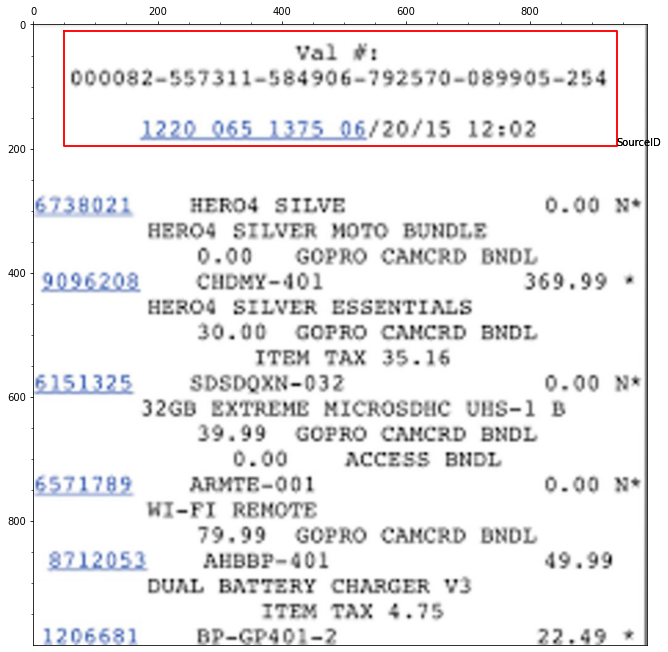

In [51]:
#@title appGUI

oGUI = AnnoGUI()
aGUI = oGUI()
oGUI.run()
clear_output(wait=True)
display(aGUI);

In [ ]:
table_file_parent_path =SysConfig.BKB_Detection_data_anno_path
table_file_name = 'Rect_rct_000001_BKBDetectionData.csv'
table_file_path = table_file_parent_path / table_file_name
table = pd.read_csv(table_file_path, index_col=0)
table

,TL_X,TL_Y,BR_X,BR_Y,BOX_W,BOX_H
DocIssuerInfo,55.0,0.0,349.0,150.0,419.0,70.0
IssuerReceivable,155.0,235.0,474.0,305.0,319.0,140.0
CashPaymentInfo,155.0,305.0,474.0,375.0,319.0,30.0
SourceID,20.0,430.0,480.0,495.0,254.0,30.0
TransactionDate,20.0,430.0,480.0,495.0,NaN,NaN


In [ ]:
ind_lst = list(table.index)
#ind_lst[0] = 'RNP'
#ind_lst[1] = 'TPB'
#table.index = ind_lst
table = table[:-1]
table

,TL_X,TL_Y,BR_X,BR_Y,BOX_W,BOX_H
DocIssuerInfo,55.0,0.0,349.0,150.0,419.0,70.0
IssuerReceivable,155.0,235.0,474.0,305.0,319.0,140.0
CashPaymentInfo,155.0,305.0,474.0,375.0,319.0,30.0
SourceID,20.0,430.0,480.0,495.0,254.0,30.0


In [ ]:
table.to_csv(table_file_path)

In [ ]:
layout = Layout(width='5%')
data_row = widgets.HBox(( widgets.IntText(layout=layout), widgets.Dropdown(options=['a', 'b', 'c'], layout=layout) ))
lbl_row  = widgets.HBox([ widgets.Label('lbl', layout=layout), widgets.Label('dd')])
btn = widgets.Label(description='click')
display( widgets.VBox((lbl_row, data_row, btn)))
btn.value='aa'

# crop box

In [ ]:
def crop_box(box_img, box_quad):
  '''
    args:
      box_img{ndarray} - the image contains box
      box_quad{ndarray} - the coordinates of box (lft-top, clockwisely to lft_btm)
  '''
  # 4 take the box from image by correcting perspective distortion
  # correct the distortion caused by perspective transform
  # copy tensor to cpu memory so that it can be converted into numpy
  # d = distance.pdist(lta_coords.cpu())  
  d = distance.pdist(box_quad)
  w = int(max(d[0], d[5])) # = max(dist(p1, p2), dist(p3, p4))    
  h = int(max(d[2], d[3])) # = max(dist(p1, p4), dist(p2, p3))    
  # create a projective transform
  tr = transform.ProjectiveTransform()
  # src = np.array([[0,h], [w,h], [w,0], [0,0]]) # src to create transformation
  # from lft_top, clockwisely to lft_btm: lft_top, rgt_top, rgt_btm, lft_btm
  src = np.array([[0,0], [w,0], [w,h], [0,h]]) # src to create transformation
  #dst = lta_coords.cpu().detach().numpy()
  dst = box_quad # result of transformation
  # estimate the parameter of transform
  tr.estimate(src, dst )
  # warp    
  box = transform.warp(box_img, tr, output_shape=(h, w), order=1, mode="reflect")
  return box

# Transaction TYpe
1. Void : 1219
1. Refund
1. Normal

In [ ]:
lbl = widgets.IntText(layout=Layout(width='5%'))
btn = widgets.Button(description='click')
display(widgets.HBox((lbl, btn)))

#img = img.transpose(Image.FLIP_TOP_BOTTOM)
boxImg=crop_box(img, box_quad)
plt.imshow(boxImg);

# Reference
1. [Builtin functions](https://colab.research.google.com/drive/1PVN6aKbxGrc9tZE8eML9oW9aOIqNmjgk#scrollTo=ad5ubR6jb0-Z)
1. [WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms)
1. [Colab forms](https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=eFN7-fUKs-Bu)

# End
[Top](#scrollTo=lDPQeWYGmyzn)

#Version 10
1.add function to add BKB

#Version 09
1. use .csv file instead of txt file to store data
1. unify the name of BKB

# Version 08
add lable to show the total number of images to be processed

# Version 07
After saving a BKB, app auto select the next BKB

# Version 06

When restart, automatically load the  next un-annotated image 

# Version 05
use widgets Output to refresh a cell output to make GUI work smoothly
[Example](https://colab.research.google.com/drive/1hdCh8WGpze5DDfD9riIjzgG04iGSZ3IZ#scrollTo=cTDOj6hVJ5DM&uniqifier=1)

# Version 04

1. change function of BKB shown status  into class
1. change BKB Para ui into class

# Example receipts:
1. not align receipt: 2048